# **Homework 3** Problem 2

In [1]:
%matplotlib inline

## Prepare CIFAR-50 Dataset

Download dataset to your Google Drive from https://drive.google.com/drive/folders/1WGUKBP5Eta9DAltK1WtvRbX43iwP08DU?usp=sharing (please use your UW account to get access).

Unzip the files.

In [87]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)

1.10.0+cu111


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls ./drive/MyDrive

In [9]:
!unzip ./drive/MyDrive/cifar50.zip -d ./

Archive:  ./drive/MyDrive/cifar50.zip
  inflating: ./cifar50/cifar50_imbalance_0.02.zip  
  inflating: ./cifar50/cifar50.zip   


In [ ]:
!mkdir /content/data
!unzip ./cifar50/cifar50.zip -d /content/data/cifar50/
!unzip ./cifar50/cifar50_imbalance_0.02.zip -d /content/data/cifar50_imbalance_0.02/
!rm -r ./cifar50

Load and print label files to know the format of the provided labels.
- `cifar50_train.json`
- `cifar50_imbalance_0.02_train.json`

In [17]:
# TODO: load json files and print.
import json

with open ("/content/data/cifar50/cifar50_train.json", mode='r') as f:
    json_dump=f.read()
cifar50_train_json = json.loads(json_dump)

with open ("/content/data/cifar50_imbalance/cifar50_imbalance_0.02_train.json", mode='r') as f:
    json_dump=f.read()
cifar50_imbalance_train_json = json.loads(json_dump)


In [18]:
import pprint
print("cifar50_train.json (truncated): ")
pprint.pprint(cifar50_train_json['annotations'][0:5])

print("\n\ncifar50_imbalance_0.02_train.json (truncated): ")
pprint.pprint(cifar50_imbalance_train_json['annotations'][0:5])

cifar50_train.json (truncated): 
[{'category': 'apple',
  'category_id': 0,
  'fpath': 'data\\cifar50\\images\\apple\\train_0.jpg',
  'image_id': 0},
 {'category': 'telephone',
  'category_id': 86,
  'fpath': 'data\\cifar50\\images\\telephone\\train_1.jpg',
  'image_id': 1},
 {'category': 'train',
  'category_id': 90,
  'fpath': 'data\\cifar50\\images\\train\\train_2.jpg',
  'image_id': 2},
 {'category': 'cup',
  'category_id': 28,
  'fpath': 'data\\cifar50\\images\\cup\\train_3.jpg',
  'image_id': 3},
 {'category': 'willow_tree',
  'category_id': 96,
  'fpath': 'data\\cifar50\\images\\willow_tree\\train_4.jpg',
  'image_id': 4}]


cifar50_imbalance_0.02_train.json (truncated): 
[{'category': 'apple',
  'category_id': 0,
  'fpath': 'data\\cifar50_imbalance_0.02\\images\\apple\\train_0.jpg',
  'image_id': 0},
 {'category': 'apple',
  'category_id': 0,
  'fpath': 'data\\cifar50_imbalance_0.02\\images\\apple\\train_1.jpg',
  'image_id': 1},
 {'category': 'apple',
  'category_id': 0,
  'fp

In [249]:
class CIFAR50(Dataset):
  def __init__(self, json_file,root_dir,transform=None):
    
    self.category_dict = {}
    self.category_count_dict = {}
    with open (json_file, mode='r') as f:
      json_dump = f.read()
    json_fomatted = json.loads(json_dump)

    for i in range (len(json_fomatted['annotations'])):
      category_id = int(json_fomatted['annotations'][i]['category_id']/2)
      json_fomatted['annotations'][i]['category_id'] = category_id 
      if category_id not in self.category_dict:
          self.category_dict[category_id]  = json_fomatted['annotations'][i]['category']
      
      if category_id not in self.category_count_dict:
          self.category_count_dict[category_id] = 0
      else:
          self.category_count_dict[category_id] += 1

    self.annotations = json_fomatted['annotations']
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return (len(self.annotations))
  
  def __getitem__(self,index):
    from pdb import set_trace as bp
    img_path=os.path.join(self.annotations[index]['fpath'].replace('\\','/'))
    # print(img_path)
    image_raw=cv2.imread(img_path)
    image=image_raw[:,:,::-1].copy()
    # image=rgb_formatter(image_raw)
    y_label=torch.tensor(int(self.annotations[index]['category_id']))
    if self.transform:
      image=self.transform(image)

    return (image,y_label)

trainset_balanced = CIFAR50(json_file="/content/data/cifar50/cifar50_train.json", root_dir='/content/data/cifar50/images', transform=transforms.ToTensor())
testset_balanced = CIFAR50(json_file="/content/data/cifar50/cifar50_test.json", root_dir='/content/data/cifar50/images', transform=transforms.ToTensor())

testset_imbalanced = CIFAR50(json_file="/content/data/cifar50_imbalance_0.02/cifar50_imbalance_0.02_test.json", root_dir='/content/data/cifar50_imbalance/images', transform=transforms.ToTensor())
trainset_imbalanced = CIFAR50(json_file="/content/data/cifar50_imbalance_0.02/cifar50_imbalance_0.02_train.json", root_dir='/content/data/cifar50_imbalance/images', transform=transforms.ToTensor())

BATCH_SIZE = 128
trainloader_balanced = DataLoader(trainset_balanced, batch_size=BATCH_SIZE, shuffle=True)
testloader_balanced = DataLoader(testset_balanced, batch_size=BATCH_SIZE, shuffle=True)
trainloader_imbalanced = DataLoader(trainset_imbalanced, batch_size=BATCH_SIZE, shuffle=True)
testloader_imbalanced = DataLoader(testset_imbalanced, batch_size=BATCH_SIZE, shuffle=True)

Show some images with labels (class names) from dataset.

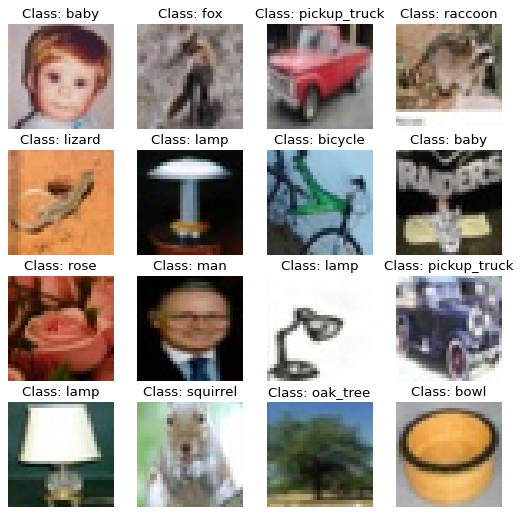

In [25]:
# TODO: visualize some data with labels.
import matplotlib.pyplot as plt 
batch_tensor, batch_labels = next(iter(trainloader_balanced))

f, axarr = plt.subplots(4,4, figsize=(8,8), dpi=80)
plt.axis('off')

for i in range(4):
    for j in range(4):
        axarr[i,j].set_axis_off()
        axarr[i,j].set_title(f"Class: {trainset_balanced.category_dict[batch_labels[4*i + j].item()]}")
        axarr[i,j].imshow(batch_tensor[4*i + j].permute(1,2,0).numpy())

## Train CNNs.

#### Use the CNN in HW2 to train the model on the balanced CIFAR50 dataset.

Train the CNN on the balanced CIFAR50 training set. Evaluate and report the classification accuracies on the testing set. 

Note: You can use any network configurations you implemented in HW2.

In [64]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 50))
        
    def forward(self, xb):
        return self.network(xb)

In [65]:
cnn_balanced = CNN().to(device)  # operate on GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_balanced.parameters(), lr=0.001)

In [40]:
n_epoch = 10
train_losses_cnn = []
train_accuracies_cnn = []

for epoch in range(n_epoch):  # loop over the dataset multiple times
  train_epoch_loss_cnn = []       # capturing loss of batches in an epoch
  correct = 0
  processed = 0
  for i, (data,target) in enumerate(trainloader_balanced):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = cnn_balanced(data)
    loss = criterion(y_pred, target)
    loss.backward()
    train_epoch_loss_cnn.append(loss.item())
    optimizer.step()
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability    
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    if i % 50 == 0:
      print(f'Epoch={epoch}   Loss={loss.item():.5f}   Batch_id={i}   Accuracy={100*correct/processed:0.2f}')

  print("*"*100)
  train_losses_cnn.append(np.mean(np.array(train_epoch_loss_cnn)))
  train_accuracies_cnn.append(100*correct/processed)

Epoch=0   Loss=3.91545   Batch_id=0   Accuracy=1.56
Epoch=0   Loss=3.91209   Batch_id=50   Accuracy=1.95
Epoch=0   Loss=3.91443   Batch_id=100   Accuracy=1.97
Epoch=0   Loss=3.64266   Batch_id=150   Accuracy=2.58
****************************************************************************************************
Epoch=1   Loss=3.42259   Batch_id=0   Accuracy=7.03
Epoch=1   Loss=3.43366   Batch_id=50   Accuracy=7.89
Epoch=1   Loss=3.17281   Batch_id=100   Accuracy=9.41
Epoch=1   Loss=3.17158   Batch_id=150   Accuracy=10.50
****************************************************************************************************
Epoch=2   Loss=3.06512   Batch_id=0   Accuracy=17.97
Epoch=2   Loss=3.05661   Batch_id=50   Accuracy=17.28
Epoch=2   Loss=2.82189   Batch_id=100   Accuracy=19.08
Epoch=2   Loss=2.81083   Batch_id=150   Accuracy=19.99
****************************************************************************************************
Epoch=3   Loss=3.01934   Batch_id=0   Accuracy=15.62


In [43]:
torch.save(cnn_balanced.state_dict(), './cnn_cifar10_balanced.pth')

In [45]:
with torch.no_grad():
  test_epoch_loss_cnn = []       # capturing loss of batches in an epoch
  correct = 0
  processed = 0
  for i, (data, target) in enumerate(testloader_balanced):
    data, target = data.to(device), target.to(device)
    y_pred = cnn_balanced(data)
    loss = criterion(y_pred, target)
    test_epoch_loss_cnn.append(loss.item())
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability    
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    if i % 100 == 0:
      print(f'Loss={loss.item():.5f} Batch_id={i} Accuracy={100*correct/processed:0.2f}')

  print("*"*100)
  print("Test loss : ", np.mean(np.array(test_epoch_loss_cnn)))
  print("Test Accuracy : ", 100*correct/processed)

Loss=2.16531 Batch_id=0 Accuracy=46.88
****************************************************************************************************
Test loss :  2.2945925682783126
Test Accuracy :  41.22


#### Use the same CNN in HW2 to train the model on the imbalanced CIFAR50 dataset.

Train the CNN on the imbalanced CIFAR50 training set. Evaluate and report the classification accuracies on the testing set. 


In [75]:
cnn_imbalanced = CNN().to(device)  # operate on GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_imbalanced.parameters(), lr=0.001)

In [76]:
n_epoch = 10
train_losses_cnn = []
train_accuracies_cnn = []

for epoch in range(n_epoch):  # loop over the dataset multiple times
  train_epoch_loss_cnn = []       # capturing loss of batches in an epoch
  correct = 0
  processed = 0
  for i, (data,target) in enumerate(trainloader_imbalanced):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = cnn_imbalanced(data)
    loss = criterion(y_pred, target)
    loss.backward()
    train_epoch_loss_cnn.append(loss.item())
    optimizer.step()
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability    
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    if i % 50 == 0:
      print(f'Epoch={epoch}   Loss={loss.item():.5f}   Batch_id={i}   Accuracy={100*correct/processed:0.2f}')

  print("*"*100)
  train_losses_cnn.append(np.mean(np.array(train_epoch_loss_cnn)))
  train_accuracies_cnn.append(100*correct/processed)

Epoch=0   Loss=3.91685   Batch_id=0   Accuracy=0.78
Epoch=0   Loss=3.65342   Batch_id=50   Accuracy=6.73
****************************************************************************************************
Epoch=1   Loss=3.40660   Batch_id=0   Accuracy=7.03
Epoch=1   Loss=3.37038   Batch_id=50   Accuracy=7.08
****************************************************************************************************
Epoch=2   Loss=3.37952   Batch_id=0   Accuracy=8.59
Epoch=2   Loss=3.23678   Batch_id=50   Accuracy=7.57
****************************************************************************************************
Epoch=3   Loss=3.45267   Batch_id=0   Accuracy=8.59
Epoch=3   Loss=3.40288   Batch_id=50   Accuracy=9.98
****************************************************************************************************
Epoch=4   Loss=3.28419   Batch_id=0   Accuracy=17.97
Epoch=4   Loss=3.26993   Batch_id=50   Accuracy=13.64
*********************************************************************

In [77]:
torch.save(cnn_balanced.state_dict(), './cnn_cifar10_imbalanced.pth')

In [78]:
with torch.no_grad():
  test_epoch_loss_cnn = []       # capturing loss of batches in an epoch
  correct = 0
  processed = 0
  for i, (data, target) in enumerate(testloader_imbalanced):
    data, target = data.to(device), target.to(device)
    y_pred = cnn_imbalanced(data)
    loss = criterion(y_pred, target)
    test_epoch_loss_cnn.append(loss.item())
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability    
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    if i % 100 == 0:
      print(f'Loss={loss.item():.5f} Batch_id={i} Accuracy={100*correct/processed:0.2f}')

  print("*"*100)
  print("Test loss : ", np.mean(np.array(test_epoch_loss_cnn)))
  print("Test Accuracy : ", 100*correct/processed)

Loss=4.03880 Batch_id=0 Accuracy=16.41
****************************************************************************************************
Test loss :  4.2235021650791165
Test Accuracy :  10.92


## Implement Tricks for LTR

Before starting this question, please read the paper for this homework: Bag of tricks for long-tailed visual recognition with deep convolutional neural networks.

According to this paper, select at least **three** tricks to implement on the imbalanced CIFAR50 training. 

Re-weighting methods
Re-sampling methods
Mixup training
Two-stage training procedures
The proposed CAM-based sampling for DRS

**TRICK 1: Class-balanced sampling (Kang et al. 2020)**

In [157]:
# TODO: trick 2 implementation
BATCH_SIZE = 128
train_count_imbalanced = list(trainset_imbalanced.category_count_dict.values()) 
train_class_weights = 1 / torch.Tensor(train_count_imbalanced)
train_sample_weights = []
for i in range (len(trainset_imbalanced.annotations)):
    category_id = (trainset_imbalanced.annotations[i]['category_id'])
    train_sample_weights.append(train_class_weights[category_id])
trainsampler_trick2 = torch.utils.data.sampler.WeightedRandomSampler(train_sample_weights, len(train_sample_weights))
trainloader_imbalanced_trick2 = DataLoader(trainset_imbalanced, batch_size = BATCH_SIZE, sampler = trainsampler_trick2)

test_count_imbalanced = list(testset_imbalanced.category_count_dict.values())
test_class_weights = 1 / torch.Tensor(test_count_imbalanced)
test_sample_weights = []
for i in range (len(testset_imbalanced.annotations)):
    category_id = (testset_imbalanced.annotations[i]['category_id'])
    test_sample_weights.append(test_class_weights[category_id])
testsampler_trick2 = torch.utils.data.sampler.WeightedRandomSampler(test_weights, len(test_sample_weights))
testloader_imbalanced_trick2 = DataLoader(testset_imbalanced, batch_size = BATCH_SIZE, sampler = testsampler_trick2)

In [158]:
cnn_imbalanced_trick2 = CNN().to(device)  # operate on GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_imbalanced_trick2.parameters(), lr=0.001)

In [159]:
n_epoch = 10
train_losses_cnn = []
train_accuracies_cnn = []

for epoch in range(n_epoch):  # loop over the dataset multiple times
  train_epoch_loss_cnn = []       # capturing loss of batches in an epoch
  correct = 0
  processed = 0
  for i, (data,target) in enumerate(trainloader_imbalanced_trick2):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = cnn_imbalanced_trick2(data)
    loss = criterion(y_pred, target)
    loss.backward()
    train_epoch_loss_cnn.append(loss.item())
    optimizer.step()
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability    
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    if i % 50 == 0:
      print(f'Epoch={epoch}   Loss={loss.item():.5f}   Batch_id={i}   Accuracy={100*correct/processed:0.2f}')

  print("*"*100)
  train_losses_cnn.append(np.mean(np.array(train_epoch_loss_cnn)))
  train_accuracies_cnn.append(100*correct/processed)

Epoch=0   Loss=3.90847   Batch_id=0   Accuracy=0.78
Epoch=0   Loss=3.76005   Batch_id=50   Accuracy=2.88
****************************************************************************************************
Epoch=1   Loss=3.85390   Batch_id=0   Accuracy=1.56
Epoch=1   Loss=3.48900   Batch_id=50   Accuracy=6.24
****************************************************************************************************
Epoch=2   Loss=3.55358   Batch_id=0   Accuracy=6.25
Epoch=2   Loss=3.04990   Batch_id=50   Accuracy=11.51
****************************************************************************************************
Epoch=3   Loss=3.16345   Batch_id=0   Accuracy=14.06
Epoch=3   Loss=3.26272   Batch_id=50   Accuracy=20.75
****************************************************************************************************
Epoch=4   Loss=2.60085   Batch_id=0   Accuracy=28.12
Epoch=4   Loss=2.36771   Batch_id=50   Accuracy=32.61
******************************************************************

In [161]:
torch.save(cnn_imbalanced_trick2.state_dict(), './cnn_cifar10_imbalanced_trick2.pth')

In [160]:
with torch.no_grad():
  test_epoch_loss_cnn = []       # capturing loss of batches in an epoch
  correct = 0
  processed = 0
  for i, (data, target) in enumerate(testloader_imbalanced_trick2):
    data, target = data.to(device), target.to(device)
    y_pred = cnn_imbalanced_trick2(data)
    loss = criterion(y_pred, target)
    test_epoch_loss_cnn.append(loss.item())
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability    
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    if i % 100 == 0:
      print(f'Loss={loss.item():.5f} Batch_id={i} Accuracy={100*correct/processed:0.2f}')

  print("*"*100)
  print("Test loss : ", np.mean(np.array(test_epoch_loss_cnn)))
  print("Test Accuracy : ", 100*correct/processed)

Loss=4.55713 Batch_id=0 Accuracy=26.56
****************************************************************************************************
Test loss :  3.958293694257736
Test Accuracy :  29.32


**TRICK 2: Focal Loss (Lin et al. 2017)**

In [212]:
from typing import Optional
def one_hot(
    labels: torch.Tensor,
    num_classes: int,
    device: Optional[torch.device] = None,
    dtype: Optional[torch.dtype] = None,
    eps: float = 1e-6,
) -> torch.Tensor:
    if not isinstance(labels, torch.Tensor):
        raise TypeError(f"Input labels type is not a torch.Tensor. Got {type(labels)}")
    if not labels.dtype == torch.int64:
        raise ValueError(f"labels must be of the same dtype torch.int64. Got: {labels.dtype}")
    if num_classes < 1:
        raise ValueError("The number of classes must be bigger than one." " Got: {}".format(num_classes))
    shape = labels.shape
    one_hot = torch.zeros((shape[0], num_classes) + shape[1:], device=device, dtype=dtype)
    return one_hot.scatter_(1, labels.unsqueeze(1), 1.0) + eps

def focal_loss(
    input: torch.Tensor,
    target: torch.Tensor,
    alpha: float,
    gamma: float = 2.0,
    reduction: str = 'none',
    eps: Optional[float] = None,
) -> torch.Tensor:
    if eps is not None and not torch.jit.is_scripting():
        warnings.warn(
            "`focal_loss` has been reworked for improved numerical stability "
            "and the `eps` argument is no longer necessary",
            DeprecationWarning,
            stacklevel=2,
        )

    if not isinstance(input, torch.Tensor):
        raise TypeError(f"Input type is not a torch.Tensor. Got {type(input)}")

    if not len(input.shape) >= 2:
        raise ValueError(f"Invalid input shape, we expect BxCx*. Got: {input.shape}")

    if input.size(0) != target.size(0):
        raise ValueError(f'Expected input batch_size ({input.size(0)}) to match target batch_size ({target.size(0)}).')

    n = input.size(0)
    out_size = (n,) + input.size()[2:]
    if target.size()[1:] != input.size()[2:]:
        raise ValueError(f'Expected target size {out_size}, got {target.size()}')

    if not input.device == target.device:
        raise ValueError(f"input and target must be in the same device. Got: {input.device} and {target.device}")

    # compute softmax over the classes axis
    input_soft: torch.Tensor = F.softmax(input, dim=1)
    log_input_soft: torch.Tensor = F.log_softmax(input, dim=1)

    # create the labels one hot tensor
    target_one_hot: torch.Tensor = one_hot(target, num_classes=input.shape[1], device=input.device, dtype=input.dtype)

    # compute the actual focal loss
    weight = torch.pow(-input_soft + 1.0, gamma)

    focal = -alpha * weight * log_input_soft
    loss_tmp = torch.einsum('bc...,bc...->b...', (target_one_hot, focal))

    if reduction == 'none':
        loss = loss_tmp
    elif reduction == 'mean':
        loss = torch.mean(loss_tmp)
    elif reduction == 'sum':
        loss = torch.sum(loss_tmp)
    else:
        raise NotImplementedError(f"Invalid reduction mode: {reduction}")
    return loss


class FocalLoss(nn.Module):
    def __init__(self, alpha: float, gamma: float = 2.0, reduction: str = 'none', eps: Optional[float] = None) -> None:
        super().__init__()
        self.alpha: float = alpha
        self.gamma: float = gamma
        self.reduction: str = reduction
        self.eps: Optional[float] = eps

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return focal_loss(input, target, self.alpha, self.gamma, self.reduction, self.eps)


In [216]:
cnn_imbalanced_trick1 = CNN().to(device)  # operate on GPU
criterion = FocalLoss(**{"alpha": 0.5, "gamma": 2.0, "reduction": 'mean'})
optimizer = optim.Adam(cnn_imbalanced_trick1.parameters(), lr=0.001)

In [217]:
n_epoch = 10
train_losses_cnn = []
train_accuracies_cnn = []

for epoch in range(n_epoch):      # loop over the dataset multiple times
  train_epoch_loss_cnn = []       # capturing loss of batches in an epoch
  correct = 0
  processed = 0
  for i, (data,target) in enumerate(trainloader_imbalanced):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = cnn_imbalanced_trick1(data)
    loss = criterion(y_pred, target)
    loss.backward()
    train_epoch_loss_cnn.append(loss.item())
    optimizer.step()
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability    
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    if i % 50 == 0:
      print(f'Epoch={epoch}   Loss={loss.item():.5f}   Batch_id={i}   Accuracy={100*correct/processed:0.2f}')

  print("*"*100)
  train_losses_cnn.append(np.mean(np.array(train_epoch_loss_cnn)))
  train_accuracies_cnn.append(100*correct/processed)

Epoch=0   Loss=1.88401   Batch_id=0   Accuracy=2.34
Epoch=0   Loss=1.78991   Batch_id=50   Accuracy=6.53
****************************************************************************************************
Epoch=1   Loss=1.55489   Batch_id=0   Accuracy=10.16
Epoch=1   Loss=1.59931   Batch_id=50   Accuracy=7.81
****************************************************************************************************
Epoch=2   Loss=1.55964   Batch_id=0   Accuracy=8.59
Epoch=2   Loss=1.54036   Batch_id=50   Accuracy=9.63
****************************************************************************************************
Epoch=3   Loss=1.58870   Batch_id=0   Accuracy=12.50
Epoch=3   Loss=1.49654   Batch_id=50   Accuracy=14.90
****************************************************************************************************
Epoch=4   Loss=1.47099   Batch_id=0   Accuracy=17.97
Epoch=4   Loss=1.32412   Batch_id=50   Accuracy=17.92
******************************************************************

In [93]:
torch.save(cnn_imbalanced_trick1.state_dict(), './cnn_cifar10_imbalanced_trick1.pth')

In [218]:
with torch.no_grad():
  test_epoch_loss_cnn = []       # capturing loss of batches in an epoch
  correct = 0
  processed = 0
  for i, (data, target) in enumerate(testloader_imbalanced):
    data, target = data.to(device), target.to(device)
    y_pred = cnn_imbalanced_trick1(data)
    loss = criterion(y_pred, target)
    test_epoch_loss_cnn.append(loss.item())
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability    
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    if i % 100 == 0:
      print(f'Loss={loss.item():.5f} Batch_id={i} Accuracy={100*correct/processed:0.2f}')

  print("*"*100)
  print("Test loss : ", np.mean(np.array(test_epoch_loss_cnn)))
  print("Test Accuracy : ", 100*correct/processed)

Loss=1.79024 Batch_id=0 Accuracy=17.19
****************************************************************************************************
Test loss :  1.8266164541244507
Test Accuracy :  15.16


**Trick3: CLASS-BALANCED CrossEntropy LOSS (Cui et al. 2019)**

In [256]:
# TODO: trick 3 implementation
from pdb import set_trace as bp

class CBLoss(nn.Module):
    def __init__(self, beta: float, samples_per_cls: list, num_classes: int) -> None:
        super().__init__()
        self.beta: float = beta
        self.samples_per_cls: list = samples_per_cls
        self.num_classes: int = num_classes
        effective_num = 1.0 - torch.pow(beta, samples_per_cls)
        self.weights = (1.0 - beta) / effective_num
        self.weights = ((weights / torch.sum(weights)) * num_classes).to(device)

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return F.cross_entropy(input = input, target = target, weight = self.weights)

In [257]:
cnn_imbalanced_trick3 = CNN().to(device)  # operate on GPU
samples_per_cls = torch.tensor(list(trainset_imbalanced.category_count_dict.values())).to(device)
criterion = CBLoss(**{"beta": 0.999, "samples_per_cls":samples_per_cls, "num_classes":50})
optimizer = optim.Adam(cnn_imbalanced_trick3.parameters(), lr=0.001)

In [258]:
n_epoch = 10
train_losses_cnn = []
train_accuracies_cnn = []

for epoch in range(n_epoch):  # loop over the dataset multiple times
  train_epoch_loss_cnn = []       # capturing loss of batches in an epoch
  correct = 0
  processed = 0
  for i, (data,target) in enumerate(trainloader_imbalanced):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = cnn_imbalanced_trick3(data)
    loss = criterion(y_pred, target)
    loss.backward()
    train_epoch_loss_cnn.append(loss.item())
    optimizer.step()
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability    
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    if i % 50 == 0:
      print(f'Epoch={epoch}   Loss={loss.item():.5f}   Batch_id={i}   Accuracy={100*correct/processed:0.2f}')

  print("*"*100)
  train_losses_cnn.append(np.mean(np.array(train_epoch_loss_cnn)))
  train_accuracies_cnn.append(100*correct/processed)

Epoch=0   Loss=3.91643   Batch_id=0   Accuracy=0.00
Epoch=0   Loss=3.52467   Batch_id=50   Accuracy=6.98
****************************************************************************************************
Epoch=1   Loss=3.44793   Batch_id=0   Accuracy=6.25
Epoch=1   Loss=3.14307   Batch_id=50   Accuracy=7.42
****************************************************************************************************
Epoch=2   Loss=3.32992   Batch_id=0   Accuracy=9.38
Epoch=2   Loss=3.45034   Batch_id=50   Accuracy=11.57
****************************************************************************************************
Epoch=3   Loss=3.24084   Batch_id=0   Accuracy=10.16
Epoch=3   Loss=3.28617   Batch_id=50   Accuracy=13.17
****************************************************************************************************
Epoch=4   Loss=3.39294   Batch_id=0   Accuracy=11.72
Epoch=4   Loss=2.79673   Batch_id=50   Accuracy=15.97
******************************************************************

In [259]:
torch.save(cnn_imbalanced_trick3.state_dict(), './cnn_cifar10_imbalanced_trick3.pth')

In [261]:
with torch.no_grad():
  test_epoch_loss_cnn = []       # capturing loss of batches in an epoch
  correct = 0
  processed = 0
  for i, (data, target) in enumerate(testloader_imbalanced):
    data, target = data.to(device), target.to(device)
    y_pred = cnn_imbalanced_trick3(data)
    loss = criterion(y_pred, target)
    test_epoch_loss_cnn.append(loss.item())
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability    
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    if i % 100 == 0:
      print(f'Loss={loss.item():.5f} Batch_id={i} Accuracy={100*correct/processed:0.2f}')

  print("*"*100)
  print("Test loss : ", np.mean(np.array(test_epoch_loss_cnn)))
  print("Test Accuracy : ", 100*correct/processed)

Loss=3.54938 Batch_id=0 Accuracy=14.84
****************************************************************************************************
Test loss :  3.754081577062607
Test Accuracy :  13.38


**Evaluate and report the classification performance on CIFAR50 testing set.**

I have evaluated the models after every trick. 
Results are tabulated as follows.


| Experiment name                                               | Test Accuracy | Train Accuracy | Test Loss | Train Loss |
|---------------------------------------------------------------|---------------|----------------|-----------|------------|
| Base imbalanced model                                         | 10.92         | 25.99          | 4.2235    | 2.4941     |
| Trick 1: Class-balanced sampling (Kang et al. 2020)           | 29.32         | 73.30          | 3.958     | 0.64389    |
| Trick 2: Focal Loss (Lin et al. 2017)                         | 15.16         | 33.69          | 1.8266    | 1.12064    |
| Trick 3: CLASS-BALANCED CrossEntropy LOSS (Cui et al. 2019)** | 13.38         | 28.10          | 3.754     | 3.10353    |